<a href="https://www.kaggle.com/code/dataranch/tsla-pricing-eda-model-comparison?scriptVersionId=106920281" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**TSLA Pricing Model Comparison + Feature Importance 📊**</div>
- Preprocessing
    - Detect continuous and categorical variables.
    - Normalize and impute data.
    

- For every target variable in the dataset:
    - Compare performance on 27 models + a TabNet model.
    - Output model performance and processed data in CSV format for every dataset.
    - Save plots + CSVs of XGBoost Feature Importances.
    - Save best performing FastAI model.
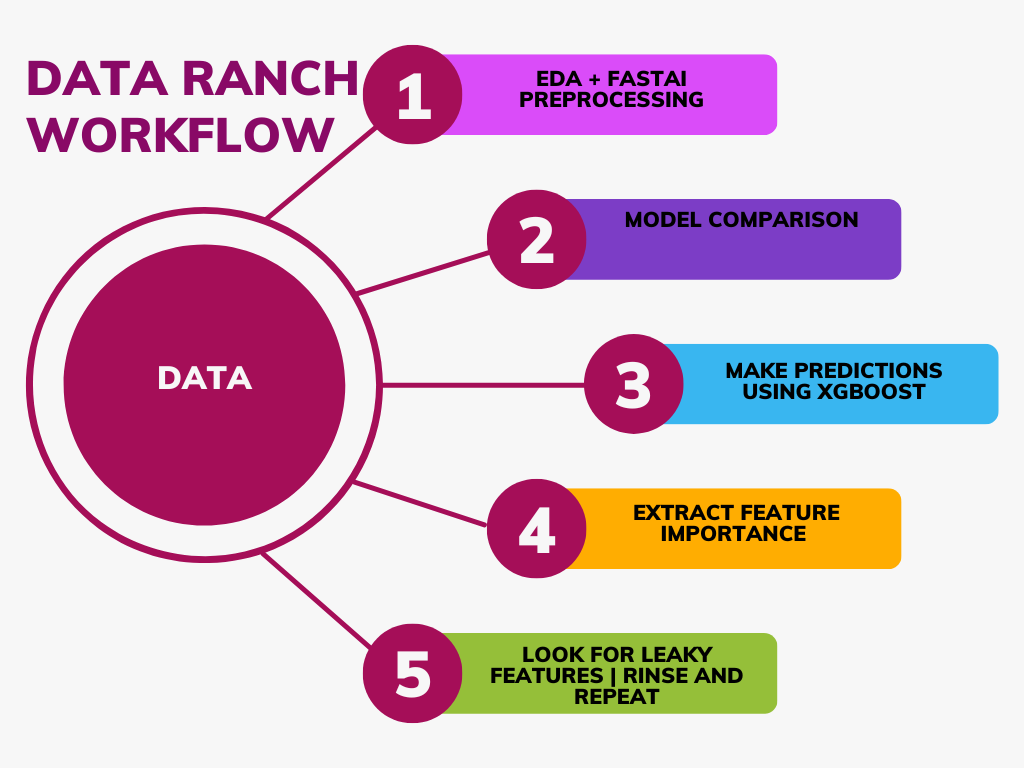

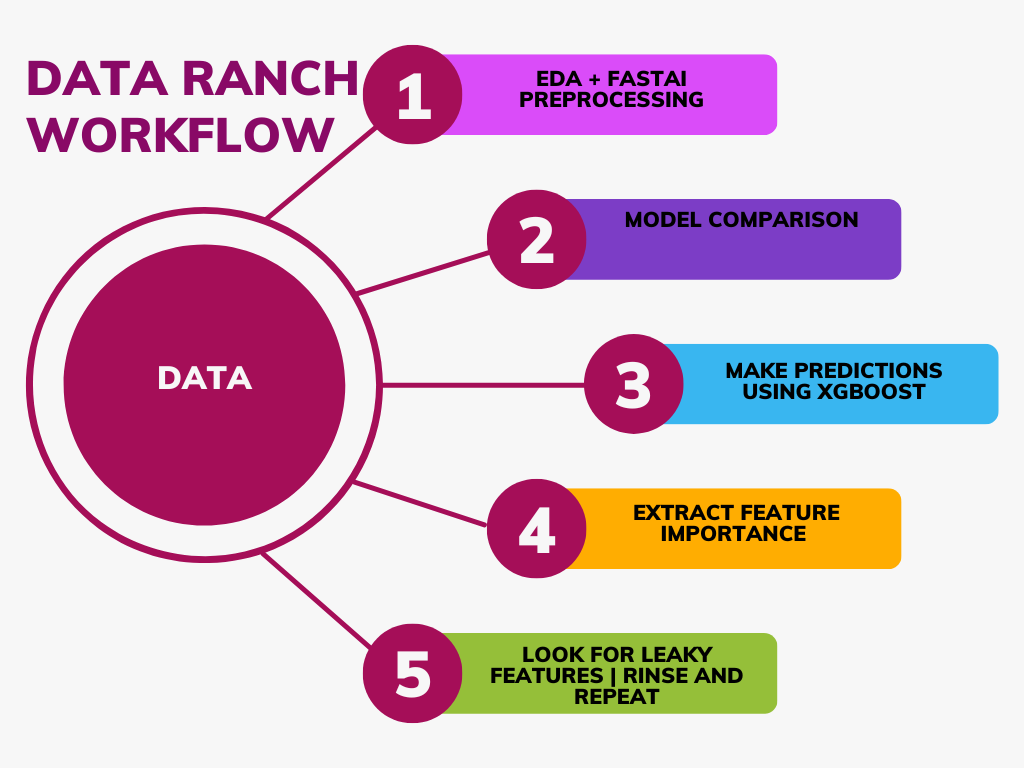

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install lazypredict

In [3]:
!pip install --upgrade pandas

In [4]:
!pip install fast-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.1 MB/s eta 0:00:00


In [5]:
!pip install fastai

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires te

In [6]:
!pip install pandas-profiling

  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.


In [7]:
#A program that takes a csv and trains models on it. Streamlined model selection.
#==============================================================================

#LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
#Baysian Optimization
from bayes_opt import BayesianOptimization
#Pandas stack
import pandas as pd
import pandas_profiling
import numpy as np
#FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#System
import os
import sys
import traceback
#Fit an xgboost model
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
#Random
import random

#TabNet
from fast_tabnet.core import *

import shutil

In [8]:
%matplotlib inline

In [9]:
#Project Variables
#===================================================================================================
PROJECT_NAME = 'tesla-stock-pricing-20172022'
VARIABLE_FILES = False
#Maximum amount of rows to take
SAMPLE_COUNT = 20000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUST_LEARNING_RATE = False
#Set to True automatically infer if variables are categorical or continuous
ENABLE_BREAKPOINT = True
#When trying to declare a column a continuous variable, if it fails, convert it to a categorical variable
CONVERT_TO_CAT = False
REGRESSOR = True
SEP_DOLLAR = True
SEP_PERCENT = True
SHUFFLE_DATA = True

In [10]:
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
#rename any file in param_dir/file that ends with csv to data.csv
for file in os.listdir(input_dir):
    if file.endswith('.csv'):
        print('CSV!')
        if 'classification_results' not in file and 'regression_results' not in file:
            #os.rename(f'{input_dir}/{file}', f'{param_dir}/data.csv')
            shutil.copy(f'{input_dir}/{file}', f'{param_dir}/data.csv')
        #os.rename(f'{param_dir}/{file}', f'{param_dir}/data.csv')
try:
    df = pd.read_csv(f'{param_dir}/data.csv', nrows=SAMPLE_COUNT)
except:
    print(f'Please place a file named data.csv in {param_dir}')
    #sys.exit()

param_dir: /kaggle/working/tesla-stock-pricing-20172022
CSV!


In [11]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-18,25.35,25.97,25.18,25.67,25.67,107820000
1,2017-09-19,25.33,25.49,24.90,25.01,25.01,96778500
2,2017-09-20,24.87,25.22,24.74,24.93,24.93,73786500
3,2017-09-21,24.99,25.12,24.30,24.43,24.43,69273000
4,2017-09-22,24.43,24.66,23.39,23.41,23.41,122391000
...,...,...,...,...,...,...,...
1254,2022-09-12,300.72,305.49,300.40,304.42,304.42,48674600
1255,2022-09-13,292.90,297.40,290.40,292.13,292.13,68229600
1256,2022-09-14,292.24,306.00,291.64,302.61,302.61,72628700
1257,2022-09-15,301.83,309.12,300.72,303.75,303.75,64795500


In [12]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [13]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

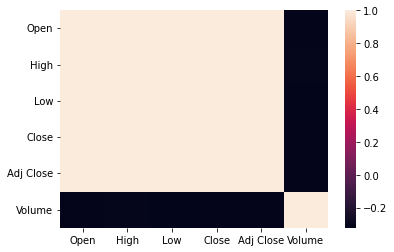

In [14]:
sns.heatmap(df.corr())

In [15]:
df.head().style.background_gradient(cmap = "inferno")

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-09-18,25.35,25.97,25.18,25.67,25.67,107820000
1,2017-09-19,25.33,25.49,24.90,25.01,25.01,96778500
2,2017-09-20,24.87,25.22,24.74,24.93,24.93,73786500
3,2017-09-21,24.99,25.12,24.30,24.43,24.43,69273000
4,2017-09-22,24.43,24.66,23.39,23.41,23.41,122391000


In [16]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Open,1259.00,121.34,118.69,12.07,20.81,47.39,233.38,411.47
High,1259.00,124.14,121.41,12.45,21.13,49.58,238.44,414.50
Low,1259.00,118.31,115.65,11.80,20.35,45.80,227.15,405.67
Close,1259.00,121.31,118.57,11.93,20.78,48.30,233.14,409.97
Adj Close,1259.00,121.31,118.57,11.93,20.78,48.30,233.14,409.97
Volume,1259.00,132004874.03,90257111.18,29401800.00,75423750.00,101611500.00,152689500.00,914082000.00


In [17]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [18]:
#remove leaky date feature
del(df['Date'])

Target Variable: Volume
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Close', 'Adj Close']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Close', 'Adj Close']
Categorical variables that made the cut : []
Tabular Object size: 1259


 19%|█▉        | 8/42 [00:00<00:00, 38.49it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.2844763766247219, 'Adjusted R-Squared': 0.26987385369869576, 'RMSE': 70880283.40673324, 'Time taken': 0.06319713592529297}
{'Model': 'BaggingRegressor', 'R-Squared': 0.5545755232035142, 'Adjusted R-Squared': 0.5454852277586879, 'RMSE': 55924292.20463601, 'Time taken': 0.056273698806762695}
{'Model': 'BayesianRidge', 'R-Squared': -0.0007498437338853137, 'Adjusted R-Squared': -0.021173309932535966, 'RMSE': 83825513.48636717, 'Time taken': 0.03376317024230957}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.3668267815932412, 'Adjusted R-Squared': 0.3539048791767767, 'RMSE': 66676796.43801439, 'Time taken': 0.01542353630065918}
{'Model': 'DummyRegressor', 'R-Squared': -0.0007498279565514299, 'Adjusted R-Squared': -0.021173293833215867, 'RMSE': 83825510.0, 'Time taken': 0.009774208068847656}
{'Model': 'ElasticNet', 'R-Squared': 0.1171625818679417, 'Adjusted R-Squared': 0.09914549170198128, 'RMSE': 78732456.0, 'Time taken': 0.01454019546508789}

 29%|██▊       | 12/42 [00:00<00:02, 10.48it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.5371802345651391, 'Adjusted R-Squared': 0.5277349332297337, 'RMSE': 57005847.40106695, 'Time taken': 0.2731442451477051}


 40%|████      | 17/42 [00:01<00:02, 10.01it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.5332697202057111, 'Adjusted R-Squared': 0.5237446124548072, 'RMSE': 57246171.275357485, 'Time taken': 0.4094681739807129}
{'Model': 'HuberRegressor', 'R-Squared': -0.004481705379785428, 'Adjusted R-Squared': -0.024981332020189262, 'RMSE': 83981663.46068843, 'Time taken': 0.022702455520629883}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.43988457333725484, 'Adjusted R-Squared': 0.42845364626250493, 'RMSE': 62712228.0, 'Time taken': 0.012063026428222656}
{'Model': 'KernelRidge', 'R-Squared': -2.3047930029171693, 'Adjusted R-Squared': -2.3722377580787444, 'RMSE': 152330050.0, 'Time taken': 0.06772255897521973}
{'Model': 'Lars', 'R-Squared': 0.18363948795660723, 'Adjusted R-Squared': 0.16697906934347673, 'RMSE': 75710210.0, 'Time taken': 0.04849553108215332}


 48%|████▊     | 20/42 [00:01<00:01, 12.58it/s]

{'Model': 'LarsCV', 'R-Squared': 0.1838202562766581, 'Adjusted R-Squared': 0.16716352681291646, 'RMSE': 75701830.0, 'Time taken': 0.0648951530456543}
{'Model': 'Lasso', 'R-Squared': 0.19469778629239487, 'Adjusted R-Squared': 0.1782630472371376, 'RMSE': 75195680.0, 'Time taken': 0.014999628067016602}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (2,3) we computed 817.8287353515625 but the user-supplied value was 817.8285522460938.
{'Model': 'LassoLars', 'R-Squared': 0.18363992485773462, 'Adjusted R-Squared': 0.16697951516095366, 'RMSE': 75710190.0, 'Time taken': 0.011556148529052734}
{'Model': 'LassoLarsCV', 'R-Squared': 0.1838202562766581, 'Adjusted R-Squared': 0.16716352681291646, 'RMSE': 75701830.0, 'Time taken': 0.019707918167114258}
{'Model': 'LassoLarsIC', 'R-Squared': 0.18363948795660723, 'Adjusted R-Squared': 0.16697906934347673, 

 67%|██████▋   | 28/42 [00:03<00:02,  6.23it/s]

{'Model': 'MLPRegressor', 'R-Squared': -2.413106112325351, 'Adjusted R-Squared': -2.482761339107501, 'RMSE': 154806200.0, 'Time taken': 1.6483066082000732}
{'Model': 'NuSVR', 'R-Squared': -0.036532469938457934, 'Adjusted R-Squared': -0.05768619381475304, 'RMSE': 85310976.39548986, 'Time taken': 0.1339728832244873}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.12166562188639896, 'Adjusted R-Squared': 0.10374043049632542, 'RMSE': 78531410.46522947, 'Time taken': 0.011151552200317383}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.1638901595592639, 'Adjusted R-Squared': 0.1468266934278203, 'RMSE': 76620525.1678856, 'Time taken': 0.016254663467407227}


 74%|███████▍  | 31/42 [00:03<00:01,  8.00it/s]

{'Model': 'PassiveAggressiveRegressor', 'R-Squared': -2.375895079254863, 'Adjusted R-Squared': -2.44479089719884, 'RMSE': 153960008.79997283, 'Time taken': 0.07158017158508301}
{'Model': 'PoissonRegressor', 'R-Squared': 0.04536921192909005, 'Adjusted R-Squared': 0.025886950948051046, 'RMSE': 81871203.65890795, 'Time taken': 0.022143125534057617}


 79%|███████▊  | 33/42 [00:31<00:26,  2.93s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.11440234092029256, 'Adjusted R-Squared': -0.13714524583703325, 'RMSE': 88457460.01931301, 'Time taken': 27.35483741760254}
{'Model': 'RANSACRegressor', 'R-Squared': -0.20231465301784057, 'Adjusted R-Squared': -0.22685168675289846, 'RMSE': 91880330.0, 'Time taken': 0.15329432487487793}


 90%|█████████ | 38/42 [00:31<00:05,  1.32s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.5460396662208287, 'Adjusted R-Squared': 0.5367751696130905, 'RMSE': 56457599.72120244, 'Time taken': 0.4340529441833496}
{'Model': 'Ridge', 'R-Squared': 0.1849717532947852, 'Adjusted R-Squared': 0.16833852377018899, 'RMSE': 75648410.0, 'Time taken': 0.01140904426574707}
{'Model': 'RidgeCV', 'R-Squared': 0.18760688550832505, 'Adjusted R-Squared': 0.17102743419216837, 'RMSE': 75526015.58934787, 'Time taken': 0.012520074844360352}
{'Model': 'SGDRegressor', 'R-Squared': 0.11953459444638115, 'Adjusted R-Squared': 0.10156591270038895, 'RMSE': 78626619.76672879, 'Time taken': 0.011644840240478516}
{'Model': 'SVR', 'R-Squared': -0.11515137599854897, 'Adjusted R-Squared': -0.13790956734545823, 'RMSE': 88487182.95158166, 'Time taken': 0.08261275291442871}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.16570695747298447, 'Adjusted R-Squared': 0.14868056884998415, 'RMSE': 76537230.0, 'Time taken': 0.011401176452636719}
{'Model': 'TweedieReg

100%|██████████| 42/42 [00:32<00:00,  1.30it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.5323687702793151, 'Adjusted R-Squared': 0.5228252757952194, 'RMSE': 57301396.0, 'Time taken': 0.5272731781005859}
{'Model': 'LGBMRegressor', 'R-Squared': 0.521888902416386, 'Adjusted R-Squared': 0.5121315330779448, 'RMSE': 57939917.05487476, 'Time taken': 0.16868805885314941}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: Volume
Volume
Target Standard Deviation: 91745968.0
                               Adjusted R-Squared  R-Squared         RMSE  \
Model                                                                       
BaggingRegressor                             0.55       0.55  55924292.20   
RandomForestRegressor                        0.54       0.55  56457599.72   
GradientBoostingRegressor                    0.53       0.54  57005847.40   
HistGradientBoostingRegressor                0.52       0.53  57246171.28   
XGBRegressor                                 0.52       0.53  57301396.00   
LGBMRegressor   

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,25831256168071168.000000,23965075698089984.000000,154806576.000000,00:00
1,25509934632271872.000000,23965026305966080.000000,154806416.000000,00:00
2,25269603294773248.000000,23964560302014464.000000,154804912.000000,00:00
3,25441563047886848.000000,23943643811282944.000000,154737344.000000,00:00
4,25734402508062720.000000,23935479078453248.000000,154710944.000000,00:00
5,25723924935344128.000000,23877670966132736.000000,154524016.000000,00:00
6,25808696852348928.000000,23886956685426688.000000,154554064.000000,00:00


Better model found at epoch 0 with _rmse value: 154806576.0.
Better model found at epoch 1 with _rmse value: 154806416.0.
Better model found at epoch 2 with _rmse value: 154804912.0.
Better model found at epoch 3 with _rmse value: 154737344.0.
Better model found at epoch 4 with _rmse value: 154710944.0.
Better model found at epoch 5 with _rmse value: 154524016.0.
No improvement since epoch 5: early stopping


,Open,High,Low,Close,Adj Close,Volume,Volume_pred
0,1.79,1.74,1.52,1.46,1.46,136133696.00,67447.61
1,0.97,0.96,1.02,1.00,1.00,41501400.00,27961.48
2,0.90,0.90,0.95,0.91,0.91,56774700.00,32012.62
3,1.01,0.97,1.05,1.00,1.00,38758800.00,26895.31
4,-0.89,-0.89,-0.88,-0.88,-0.88,80311504.00,489754.12
5,1.02,1.02,1.06,1.05,1.05,85110000.00,23940.14
6,-0.80,-0.81,-0.80,-0.80,-0.80,75405000.00,475904.97
7,0.18,0.18,0.20,0.20,0.20,144436800.00,247261.97
8,-0.83,-0.84,-0.83,-0.84,-0.84,74097000.00,481231.47


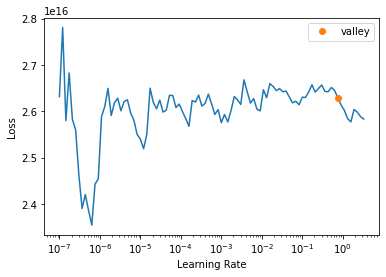

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
        actual    predicted
0 103674304.00  99131392.00
1 249061792.00 224145568.00
2 104796000.00  73597216.00
3 177317408.00 128157296.00
4  98605504.00  79201928.00
XGBoost RMSE:  57301396.0


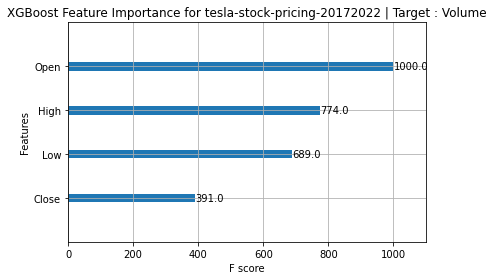

Target Variable: Adj Close
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 1259


 14%|█▍        | 6/42 [00:00<00:01, 27.58it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9983775504910435, 'Adjusted R-Squared': 0.998344439276575, 'RMSE': 4.956902015117302, 'Time taken': 0.14586520195007324}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9999498971667704, 'Adjusted R-Squared': 0.9999488746599698, 'RMSE': 0.871075665825735, 'Time taken': 0.055364370346069336}
{'Model': 'BayesianRidge', 'R-Squared': 0.999999999999998, 'Adjusted R-Squared': 0.999999999999998, 'RMSE': 5.471782001159304e-06, 'Time taken': 0.011378765106201172}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9999235593333561, 'Adjusted R-Squared': 0.9999219993197511, 'RMSE': 1.0759373204830647, 'Time taken': 0.016007423400878906}
{'Model': 'DummyRegressor', 'R-Squared': -0.02121986685326016, 'Adjusted R-Squared': -0.04206108862577573, 'RMSE': 124.361046, 'Time taken': 0.009929656982421875}
{'Model': 'ElasticNet', 'R-Squared': 0.9848872309634564, 'Adjusted R-Squared': 0.9845788071055678, 'RMSE': 15.128531, 'Time taken': 0.010276079177856445}
Elastic

 24%|██▍       | 10/42 [00:00<00:01, 18.73it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9999552290742747, 'Adjusted R-Squared': 0.9999543153819129, 'RMSE': 0.823422587664097, 'Time taken': 0.2456371784210205}
{'Model': 'GammaRegressor', 'R-Squared': 0.8740315631848357, 'Adjusted R-Squared': 0.8714607787600364, 'RMSE': 43.67728242735078, 'Time taken': 0.012989997863769531}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9999880570741592, 'Adjusted R-Squared': 0.9999878133409787, 'RMSE': 0.4252850406806533, 'Time taken': 0.14164257049560547}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999587198396201, 'Adjusted R-Squared': 0.9999578773873675, 'RMSE': 0.7906703022927845, 'Time taken': 0.26523900032043457}


 38%|███▊      | 16/42 [00:01<00:02, 10.33it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9996322269498303, 'Adjusted R-Squared': 0.9996247213773779, 'RMSE': 2.3600146005248894, 'Time taken': 0.38234853744506836}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999979, 'Adjusted R-Squared': 0.9999999999999979, 'RMSE': 5.676435321391964e-06, 'Time taken': 0.063140869140625}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9987771068008261, 'Adjusted R-Squared': 0.9987521497967613, 'RMSE': 4.3034725, 'Time taken': 0.011002063751220703}
{'Model': 'KernelRidge', 'R-Squared': 0.08271610214815417, 'Adjusted R-Squared': 0.06399602260015724, 'RMSE': 117.86277, 'Time taken': 0.03476715087890625}
{'Model': 'Lars', 'R-Squared': 0.999999998894559, 'Adjusted R-Squared': 0.999999998871999, 'RMSE': 0.004091594, 'Time taken': 0.029895305633544922}


 43%|████▎     | 18/42 [00:01<00:02, 11.45it/s]

{'Model': 'LarsCV', 'R-Squared': 0.999999999748228, 'Adjusted R-Squared': 0.9999999997430897, 'RMSE': 0.0019526685, 'Time taken': 0.08300042152404785}
{'Model': 'Lasso', 'R-Squared': 0.999682346623253, 'Adjusted R-Squared': 0.9996758639012785, 'RMSE': 2.1933174, 'Time taken': 0.01282811164855957}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (2,3) we computed 798.9253540039062 but the user-supplied value was 798.9252319335938.
{'Model': 'LassoLars', 'R-Squared': 0.9249155351539918, 'Adjusted R-Squared': 0.9233831991367264, 'RMSE': 33.720947, 'Time taken': 0.009298563003540039}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999997485128, 'Adjusted R-Squared': 0.9999999997433805, 'RMSE': 0.0019515635, 'Time taken': 0.019411563873291016}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999997415857, 'Adjusted R-Squared': 0.9999999997363119, 'RMSE':

 67%|██████▋   | 28/42 [00:03<00:02,  6.79it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9704692704800939, 'Adjusted R-Squared': 0.9698666025307081, 'RMSE': 21.147636, 'Time taken': 1.6512422561645508}
{'Model': 'NuSVR', 'R-Squared': 0.9379735283777086, 'Adjusted R-Squared': 0.9367076820180701, 'RMSE': 30.64878604994844, 'Time taken': 0.12882566452026367}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.999999999999996, 'Adjusted R-Squared': 0.9999999999999959, 'RMSE': 7.740939307870736e-06, 'Time taken': 0.009621381759643555}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.999999999999996, 'Adjusted R-Squared': 0.9999999999999959, 'RMSE': 7.740939307870736e-06, 'Time taken': 0.014096260070800781}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999979573645124, 'Adjusted R-Squared': 0.9999979156780738, 'RMSE': 0.1758815058955567, 'Time taken': 0.014394521713256836}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8621894504522045, 'Adjusted R-Squared': 0.8593769902573516, 'RMSE': 45.684194434706335, 'Time taken': 0.

 76%|███████▌  | 32/42 [00:40<00:31,  3.17s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.6308655498004521, 'Adjusted R-Squared': -0.664148520204543, 'RMSE': 157.15703202584575, 'Time taken': 37.383705854415894}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999999615, 'Adjusted R-Squared': 0.9999999999999607, 'RMSE': 2.417008e-05, 'Time taken': 0.0373997688293457}


 90%|█████████ | 38/42 [00:41<00:06,  1.71s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9999395215782934, 'Adjusted R-Squared': 0.9999382873247892, 'RMSE': 0.9570287034462697, 'Time taken': 0.44770097732543945}
{'Model': 'Ridge', 'R-Squared': 0.9997926797559428, 'Adjusted R-Squared': 0.9997884487305538, 'RMSE': 1.771926, 'Time taken': 0.012340307235717773}
{'Model': 'RidgeCV', 'R-Squared': 0.9999854255052877, 'Adjusted R-Squared': 0.9999851280666201, 'RMSE': 0.46980917339955297, 'Time taken': 0.01075291633605957}
{'Model': 'SGDRegressor', 'R-Squared': 0.9992514393507258, 'Adjusted R-Squared': 0.9992361626027815, 'RMSE': 3.3669621600283484, 'Time taken': 0.011988639831542969}
{'Model': 'SVR', 'R-Squared': 0.9415354632935723, 'Adjusted R-Squared': 0.940342309483237, 'RMSE': 29.755756441142523, 'Time taken': 0.09858918190002441}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.999999999999984, 'Adjusted R-Squared': 0.9999999999999837, 'RMSE': 1.5547666e-05, 'Time taken': 0.01613593101501465}
{'Model': 'TweedieRegressor'

100%|██████████| 42/42 [00:42<00:00,  1.02s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9997744188751759, 'Adjusted R-Squared': 0.999769815178751, 'RMSE': 1.8483156, 'Time taken': 1.2832815647125244}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9996601198103476, 'Adjusted R-Squared': 0.9996531834799466, 'RMSE': 2.2687553417844306, 'Time taken': 0.12155389785766602}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: Adj Close
Adj Close
Target Standard Deviation: 117.08863830566406
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
BayesianRidge                                1.00       1.00   0.00   
HuberRegressor                               1.00       1.00   0.00   
OrthogonalMatchingPursuit                    1.00       1.00   0.00   
OrthogonalMatchingPursuitCV                  1.00       1.00   0.00   
LinearRegression                             1.00       1.00   0.00   
TransformedTargetRegressor                  

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,21913.179688,4825.239746,69.463943,00:00
1,13509.903320,214785.687500,463.449738,00:00


Better model found at epoch 0 with _rmse value: 69.46394348144531.
No improvement since epoch 0: early stopping


,Open,High,Low,Close,Volume,Adj Close,Adj Close_pred
0,-0.54,-0.54,-0.53,-0.54,0.17,54.46,10.70
1,-0.56,-0.56,-0.56,-0.55,0.76,53.56,17.86
2,-0.15,-0.13,-0.15,-0.16,1.11,98.43,3.72
3,1.56,1.60,1.58,1.53,-0.19,297.28,257.10
4,1.59,1.57,1.62,1.62,-0.90,307.80,200.58
5,-0.88,-0.88,-0.88,-0.88,-0.39,14.81,30.52
6,1.34,1.34,1.39,1.39,-0.84,281.01,169.22
7,1.21,1.20,1.24,1.22,-0.77,260.44,146.30
8,-0.50,-0.51,-0.50,-0.51,-0.01,57.63,9.43


<Figure size 432x288 with 0 Axes>

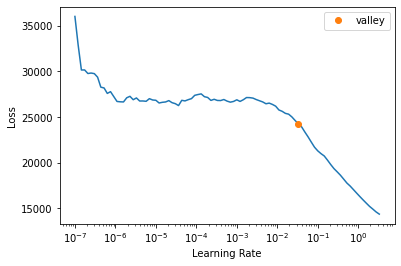

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   14.09      14.03
1  203.37     202.93
2   53.37      53.58
3  258.86     261.06
4   23.18      23.17
XGBoost RMSE:  1.8483156


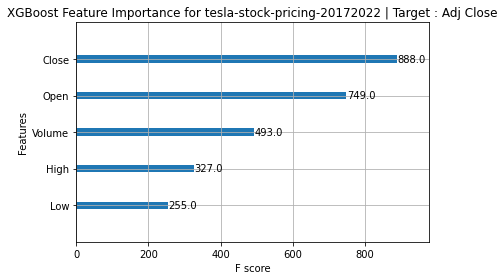

Target Variable: Close
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Low', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Low', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 1259


  0%|          | 0/42 [00:00<?, ?it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.995624159612454, 'Adjusted R-Squared': 0.995534856747402, 'RMSE': 7.963477050054725, 'Time taken': 0.045006513595581055}


  5%|▍         | 2/42 [00:00<00:02, 19.37it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.9998980173396765, 'Adjusted R-Squared': 0.9998959360608944, 'RMSE': 1.2157244890312549, 'Time taken': 0.057608604431152344}
{'Model': 'BayesianRidge', 'R-Squared': 0.999999999999997, 'Adjusted R-Squared': 0.9999999999999969, 'RMSE': 6.589703447756548e-06, 'Time taken': 0.012584209442138672}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9998366792745598, 'Adjusted R-Squared': 0.9998333461985304, 'RMSE': 1.5384828053705075, 'Time taken': 0.014428853988647461}
{'Model': 'DummyRegressor', 'R-Squared': -0.014331577337520995, 'Adjusted R-Squared': -0.0350322217729806, 'RMSE': 121.24448, 'Time taken': 0.009322643280029297}
{'Model': 'ElasticNet', 'R-Squared': 0.986529924745484, 'Adjusted R-Squared': 0.9862550252504938, 'RMSE': 13.97195, 'Time taken': 0.010538101196289062}
ElasticNetCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was comp

 21%|██▏       | 9/42 [00:00<00:01, 21.54it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9999570298510693, 'Adjusted R-Squared': 0.9999561529092543, 'RMSE': 0.7891424868063787, 'Time taken': 0.24827289581298828}
{'Model': 'GammaRegressor', 'R-Squared': 0.8646728519613432, 'Adjusted R-Squared': 0.8619110734299421, 'RMSE': 44.285796625691674, 'Time taken': 0.013809919357299805}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9999910804632964, 'Adjusted R-Squared': 0.9999908984319351, 'RMSE': 0.35953663141483205, 'Time taken': 0.15117740631103516}


 29%|██▊       | 12/42 [00:00<00:02, 13.13it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.9999095453098302, 'Adjusted R-Squared': 0.9999076992957451, 'RMSE': 1.1449526901008227, 'Time taken': 0.2371518611907959}


 40%|████      | 17/42 [00:01<00:02, 11.20it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9996233407134284, 'Adjusted R-Squared': 0.9996156537892127, 'RMSE': 2.3363953669306157, 'Time taken': 0.4018115997314453}
{'Model': 'HuberRegressor', 'R-Squared': 0.9999999999999961, 'Adjusted R-Squared': 0.999999999999996, 'RMSE': 7.461019135140797e-06, 'Time taken': 0.065338134765625}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9990354193523799, 'Adjusted R-Squared': 0.9990157340330408, 'RMSE': 3.7388775, 'Time taken': 0.012686491012573242}
{'Model': 'KernelRidge', 'R-Squared': 0.03442286798373151, 'Adjusted R-Squared': 0.014717212228297472, 'RMSE': 118.294754, 'Time taken': 0.06175589561462402}
{'Model': 'Lars', 'R-Squared': 0.9999999993847226, 'Adjusted R-Squared': 0.9999999993721659, 'RMSE': 0.0029861215, 'Time taken': 0.045389413833618164}


 50%|█████     | 21/42 [00:01<00:01, 15.59it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9999999999167501, 'Adjusted R-Squared': 0.9999999999150512, 'RMSE': 0.0010984079, 'Time taken': 0.06072258949279785}
{'Model': 'Lasso', 'R-Squared': 0.999743338042979, 'Adjusted R-Squared': 0.9997381000438561, 'RMSE': 1.928647, 'Time taken': 0.016687631607055664}
LassoCV model failed to execute
Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (2,3) we computed 814.1262817382812 but the user-supplied value was 814.1261596679688.
{'Model': 'LassoLars', 'R-Squared': 0.9264147467879467, 'Adjusted R-Squared': 0.9249130069264762, 'RMSE': 32.656334, 'Time taken': 0.010626554489135742}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9999999999167501, 'Adjusted R-Squared': 0.9999999999150512, 'RMSE': 0.0010984079, 'Time taken': 0.022172927856445312}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9999999999163282, 'Adjusted R-Squared': 0.9999999999146205, 'RMSE'

 67%|██████▋   | 28/42 [00:03<00:02,  6.19it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9630601953968108, 'Adjusted R-Squared': 0.9623063218334804, 'RMSE': 23.137651, 'Time taken': 1.6925554275512695}
{'Model': 'NuSVR', 'R-Squared': 0.9435466935897966, 'Adjusted R-Squared': 0.9423945852957109, 'RMSE': 28.603336031052386, 'Time taken': 0.13187932968139648}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9999999999999897, 'Adjusted R-Squared': 0.9999999999999895, 'RMSE': 1.2263666871872762e-05, 'Time taken': 0.010393381118774414}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9999999999999897, 'Adjusted R-Squared': 0.9999999999999895, 'RMSE': 1.2263666871872762e-05, 'Time taken': 0.015427827835083008}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9999974137541903, 'Adjusted R-Squared': 0.9999973609736635, 'RMSE': 0.19360068813853784, 'Time taken': 0.015399932861328125}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8617834036804259, 'Adjusted R-Squared': 0.8589626568167612, 'RMSE': 44.75608537345391, 'Time taken

 76%|███████▌  | 32/42 [00:35<00:29,  2.95s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.5616978802972903, 'Adjusted R-Squared': -0.59356926560948, 'RMSE': 150.44248797221124, 'Time taken': 32.14689064025879}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9999999999999688, 'Adjusted R-Squared': 0.9999999999999681, 'RMSE': 2.1269e-05, 'Time taken': 0.04759716987609863}


 90%|█████████ | 38/42 [00:36<00:06,  1.54s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9999244170356765, 'Adjusted R-Squared': 0.9999228745262004, 'RMSE': 1.0466077757151218, 'Time taken': 0.44559144973754883}
{'Model': 'Ridge', 'R-Squared': 0.9998194090581467, 'Adjusted R-Squared': 0.9998157235287212, 'RMSE': 1.6177819, 'Time taken': 0.012731552124023438}
{'Model': 'RidgeCV', 'R-Squared': 0.9999878445617539, 'Adjusted R-Squared': 0.9999875964915856, 'RMSE': 0.41971772218543707, 'Time taken': 0.010526418685913086}
{'Model': 'SGDRegressor', 'R-Squared': 0.9996231841218065, 'Adjusted R-Squared': 0.9996154940018434, 'RMSE': 2.3368809807669466, 'Time taken': 0.06837773323059082}
{'Model': 'SVR', 'R-Squared': 0.9459742675448286, 'Adjusted R-Squared': 0.9448717015763557, 'RMSE': 27.98158610827929, 'Time taken': 0.08108925819396973}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9999999999999, 'Adjusted R-Squared': 0.999999999999898, 'RMSE': 3.8080612e-05, 'Time taken': 0.01265859603881836}
{'Model': 'TweedieRegressor', 

100%|██████████| 42/42 [00:36<00:00,  1.14it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9997518725112851, 'Adjusted R-Squared': 0.9997468086849848, 'RMSE': 1.8963104, 'Time taken': 0.49666261672973633}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9997635567998315, 'Adjusted R-Squared': 0.9997587314283995, 'RMSE': 1.8511235715016507, 'Time taken': 0.1131598949432373}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: Close
Close
Target Standard Deviation: 117.87582397460938
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
BayesianRidge                                1.00       1.00   0.00   
HuberRegressor                               1.00       1.00   0.00   
OrthogonalMatchingPursuit                    1.00       1.00   0.00   
OrthogonalMatchingPursuitCV                  1.00       1.00   0.00   
RANSACRegressor                              1.00       1.00   0.00   
TransformedTargetRegressor                   1.00  

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,21724.679688,3486.482666,59.046444,00:00
1,13005.856445,395891.000000,629.198669,00:00


Better model found at epoch 0 with _rmse value: 59.046443939208984.
No improvement since epoch 0: early stopping


,Open,High,Low,Adj Close,Volume,Close,Close_pred
0,-0.83,-0.82,-0.83,-0.82,3.11,22.06,6.72
1,-0.81,-0.81,-0.80,-0.80,-0.92,23.72,6.64
2,1.38,1.43,1.44,1.46,-0.66,290.93,310.37
3,1.01,1.10,1.06,1.15,0.02,254.11,238.17
4,0.93,0.90,0.89,0.84,-0.36,217.72,214.32
5,-0.84,-0.84,-0.84,-0.84,-0.48,18.98,4.64
6,1.56,1.51,1.53,1.51,-0.88,296.07,279.89
7,0.17,0.18,0.19,0.18,0.21,139.69,21.49
8,-0.84,-0.84,-0.84,-0.84,-0.41,19.41,3.36


<Figure size 432x288 with 0 Axes>

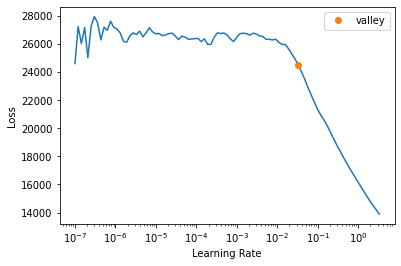

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   21.05      20.98
1  139.87     137.90
2   55.17      55.06
3   35.95      35.86
4   15.10      14.93
XGBoost RMSE:  1.8963104


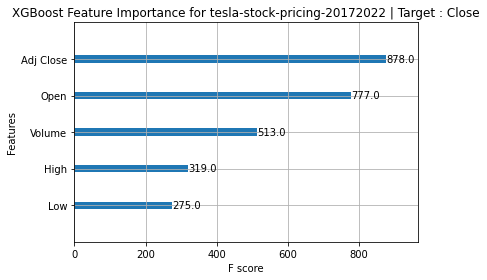

Target Variable: Low
CATS=====================
[]
CONTS=====================
['Open', 'High', 'Close', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'High', 'Close', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 1259


 17%|█▋        | 7/42 [00:00<00:01, 33.88it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9972068176436129, 'Adjusted R-Squared': 0.9971498139220539, 'RMSE': 6.02091748943953, 'Time taken': 0.13161253929138184}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9995732813063892, 'Adjusted R-Squared': 0.9995645727616217, 'RMSE': 2.3533356021241754, 'Time taken': 0.05335593223571777}
{'Model': 'BayesianRidge', 'R-Squared': 0.9996196270133113, 'Adjusted R-Squared': 0.9996118642992973, 'RMSE': 2.221866003737195, 'Time taken': 0.010462522506713867}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9990216036026979, 'Adjusted R-Squared': 0.9990016363292835, 'RMSE': 3.563448224635594, 'Time taken': 0.013959407806396484}
{'Model': 'DummyRegressor', 'R-Squared': -0.004800295412281885, 'Adjusted R-Squared': -0.02530642389008353, 'RMSE': 114.19653, 'Time taken': 0.008594036102294922}
{'Model': 'ElasticNet', 'R-Squared': 0.9868127324190736, 'Adjusted R-Squared': 0.9865436045092588, 'RMSE': 13.08249, 'Time taken': 0.009519577026367188}
ElasticNetC

 26%|██▌       | 11/42 [00:00<00:01, 15.86it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9996145143954218, 'Adjusted R-Squared': 0.9996066473422671, 'RMSE': 2.2367482844887587, 'Time taken': 0.24518179893493652}
{'Model': 'GammaRegressor', 'R-Squared': 0.856429617855241, 'Adjusted R-Squared': 0.8534996100563683, 'RMSE': 43.166363028404916, 'Time taken': 0.012989521026611328}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.5066919057903249, 'Adjusted R-Squared': 0.4966243936635968, 'RMSE': 80.0151366674872, 'Time taken': 0.13832831382751465}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.999451935726899, 'Adjusted R-Squared': 0.9994407507417338, 'RMSE': 2.6670353796076562, 'Time taken': 0.25440454483032227}


 43%|████▎     | 18/42 [00:01<00:01, 12.17it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9993457972148879, 'Adjusted R-Squared': 0.9993324461376407, 'RMSE': 2.9138636450234103, 'Time taken': 0.3895585536956787}
{'Model': 'HuberRegressor', 'R-Squared': 0.9996173843268198, 'Adjusted R-Squared': 0.9996095758436937, 'RMSE': 2.228406459723086, 'Time taken': 0.036600351333618164}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.998841834477089, 'Adjusted R-Squared': 0.9988181984460092, 'RMSE': 3.8770227, 'Time taken': 0.011953115463256836}
{'Model': 'KernelRidge', 'R-Squared': -0.04986174515032071, 'Adjusted R-Squared': -0.0712874950513478, 'RMSE': 116.72909, 'Time taken': 0.03354692459106445}
{'Model': 'Lars', 'R-Squared': 0.4776759212608904, 'Adjusted R-Squared': 0.46701624618458204, 'RMSE': 82.334724, 'Time taken': 0.01971268653869629}
{'Model': 'LarsCV', 'R-Squared': 0.9995518814853661, 'Adjusted R-Squared': 0.9995427362095572, 'RMSE': 2.4116232, 'Time taken': 0.036626338958740234}
{'Model': 'Lasso', 'R-Squared': 0.999

 57%|█████▋    | 24/42 [00:01<00:00, 19.02it/s]

{'Model': 'LassoLarsCV', 'R-Squared': 0.9995529561632649, 'Adjusted R-Squared': 0.9995438328196581, 'RMSE': 2.4087298, 'Time taken': 0.024437427520751953}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9995647982259674, 'Adjusted R-Squared': 0.9995559165571096, 'RMSE': 2.3766124, 'Time taken': 0.011504888534545898}
{'Model': 'LinearRegression', 'R-Squared': 0.9996195936146791, 'Adjusted R-Squared': 0.9996118302190603, 'RMSE': 2.2219636, 'Time taken': 0.008970260620117188}
{'Model': 'LinearSVR', 'R-Squared': 0.9994228890852352, 'Adjusted R-Squared': 0.9994111113114645, 'RMSE': 2.736797564472231, 'Time taken': 0.013365745544433594}


 67%|██████▋   | 28/42 [00:03<00:02,  5.79it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9614511583324611, 'Adjusted R-Squared': 0.9606644472780215, 'RMSE': 22.367565, 'Time taken': 1.6484010219573975}
{'Model': 'NuSVR', 'R-Squared': 0.9609590898440922, 'Adjusted R-Squared': 0.9601623365756042, 'RMSE': 22.50987055323809, 'Time taken': 0.13076257705688477}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9988093665876949, 'Adjusted R-Squared': 0.9987850679466275, 'RMSE': 3.93099112720404, 'Time taken': 0.01058650016784668}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9996195888573428, 'Adjusted R-Squared': 0.9996118253646356, 'RMSE': 2.221977440834778, 'Time taken': 0.017163991928100586}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9993683523414472, 'Adjusted R-Squared': 0.9993554615729052, 'RMSE': 2.8631920264536825, 'Time taken': 0.010897159576416016}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8757272957292745, 'Adjusted R-Squared': 0.8731911180910965, 'RMSE': 40.1606658966701, 'Time taken': 0.0156314373

 76%|███████▌  | 32/42 [00:42<00:30,  3.10s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.5459969473984787, 'Adjusted R-Squared': -0.5775479055086519, 'RMSE': 141.65025043180117, 'Time taken': 39.52551293373108}
{'Model': 'RANSACRegressor', 'R-Squared': 0.999619594087764, 'Adjusted R-Squared': 0.9996118307018, 'RMSE': 2.221962, 'Time taken': 0.05557990074157715}


 90%|█████████ | 38/42 [00:43<00:06,  1.74s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.999589218293317, 'Adjusted R-Squared': 0.9995808349931806, 'RMSE': 2.3089715304633875, 'Time taken': 0.5282940864562988}
{'Model': 'Ridge', 'R-Squared': 0.9994880803080619, 'Adjusted R-Squared': 0.9994776329674101, 'RMSE': 2.5775907, 'Time taken': 0.011582374572753906}
{'Model': 'RidgeCV', 'R-Squared': 0.9996002420549877, 'Adjusted R-Squared': 0.9995920837295792, 'RMSE': 2.277778989231397, 'Time taken': 0.010984182357788086}
{'Model': 'SGDRegressor', 'R-Squared': 0.9994125494867565, 'Adjusted R-Squared': 0.999400560700772, 'RMSE': 2.7612051480705104, 'Time taken': 0.012918472290039062}
{'Model': 'SVR', 'R-Squared': 0.9631327383082839, 'Adjusted R-Squared': 0.9623803452125347, 'RMSE': 21.87426511697934, 'Time taken': 0.08387970924377441}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9996195936146791, 'Adjusted R-Squared': 0.9996118302190603, 'RMSE': 2.2219636, 'Time taken': 0.01203155517578125}
{'Model': 'TweedieRegressor', 'R-S

100%|██████████| 42/42 [00:44<00:00,  1.05s/it]

{'Model': 'XGBRegressor', 'R-Squared': 0.9992386012026339, 'Adjusted R-Squared': 0.9992230624516673, 'RMSE': 3.1435409, 'Time taken': 0.49423718452453613}
{'Model': 'LGBMRegressor', 'R-Squared': 0.999489967930545, 'Adjusted R-Squared': 0.9994795591128011, 'RMSE': 2.5728340382182338, 'Time taken': 0.1250150203704834}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: Low
Low
Target Standard Deviation: 115.96155548095703
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
BayesianRidge                                1.00       1.00   2.22   
RANSACRegressor                              1.00       1.00   2.22   
TransformedTargetRegressor                   1.00       1.00   2.22   
LinearRegression                             1.00       1.00   2.22   
OrthogonalMatchingPursuitCV                  1.00       1.00   2.22   
HuberRegressor                               1.00       

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,22645.501953,4889.232910,69.923050,00:00
1,14087.571289,115492.304688,339.841583,00:00


Better model found at epoch 0 with _rmse value: 69.92304992675781.
No improvement since epoch 0: early stopping


,Open,High,Close,Adj Close,Volume,Low,Low_pred
0,-0.74,-0.74,-0.76,-0.76,1.98,29.48,13.24
1,1.12,1.12,1.11,1.11,0.03,249.70,143.89
2,-0.72,-0.72,-0.72,-0.72,1.03,33.20,11.12
3,-0.79,-0.79,-0.79,-0.79,-0.27,25.18,-0.29
4,-0.83,-0.82,-0.82,-0.82,0.74,21.50,7.69
5,-0.84,-0.84,-0.85,-0.85,0.86,18.48,9.18
6,0.88,0.84,0.86,0.86,-0.68,216.28,106.20
7,-0.88,-0.89,-0.89,-0.89,-0.11,14.10,0.00
8,-0.80,-0.81,-0.81,-0.81,-0.14,23.08,-2.11


<Figure size 432x288 with 0 Axes>

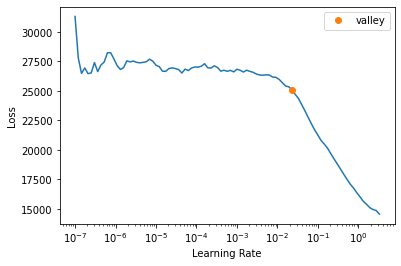

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0   21.87      21.34
1   24.29      24.12
2  310.00     295.10
3   19.91      20.00
4   22.80      22.28
XGBoost RMSE:  3.1435409


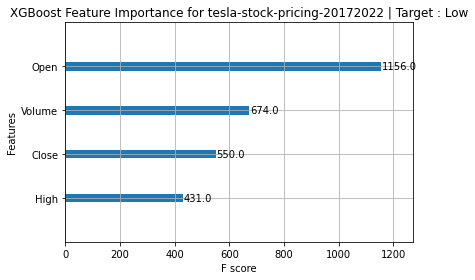

Target Variable: High
CATS=====================
[]
CONTS=====================
['Open', 'Low', 'Close', 'Adj Close', 'Volume']
5
Looping through continuous variables to find breakpoint
Continuous variables that made the cut : ['Open', 'Low', 'Close', 'Adj Close', 'Volume']
Categorical variables that made the cut : []
Tabular Object size: 1259


 14%|█▍        | 6/42 [00:00<00:01, 28.08it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.9978134559933579, 'Adjusted R-Squared': 0.9977688326462836, 'RMSE': 5.684114106994945, 'Time taken': 0.1430344581604004}
{'Model': 'BaggingRegressor', 'R-Squared': 0.9996204274514288, 'Adjusted R-Squared': 0.9996126810728865, 'RMSE': 2.3682692409097155, 'Time taken': 0.05619692802429199}
{'Model': 'BayesianRidge', 'R-Squared': 0.9997436601176292, 'Adjusted R-Squared': 0.9997384286914583, 'RMSE': 1.9462192633382915, 'Time taken': 0.011191844940185547}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.9993630919192468, 'Adjusted R-Squared': 0.9993500937951497, 'RMSE': 3.067764771740195, 'Time taken': 0.014386892318725586}
{'Model': 'DummyRegressor', 'R-Squared': -0.006512268128570975, 'Adjusted R-Squared': -0.02705333482507255, 'RMSE': 121.9532, 'Time taken': 0.009637832641601562}
{'Model': 'ElasticNet', 'R-Squared': 0.9861826764155416, 'Adjusted R-Squared': 0.9859006902199404, 'RMSE': 14.288796, 'Time taken': 0.009995460510253906}
{'Model': 

 24%|██▍       | 10/42 [00:00<00:01, 16.51it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.9997043604626402, 'Adjusted R-Squared': 0.9996983270026941, 'RMSE': 2.090089740489827, 'Time taken': 0.24901914596557617}
{'Model': 'GammaRegressor', 'R-Squared': 0.8845746422163591, 'Adjusted R-Squared': 0.8822190226697542, 'RMSE': 41.298501255998495, 'Time taken': 0.013182640075683594}
{'Model': 'GaussianProcessRegressor', 'R-Squared': 0.9617044910543388, 'Adjusted R-Squared': 0.9609229500554477, 'RMSE': 23.787981895413715, 'Time taken': 0.13556742668151855}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.99958862072791, 'Adjusted R-Squared': 0.9995802252325612, 'RMSE': 2.4654992750046483, 'Time taken': 0.2661709785461426}


 38%|███▊      | 16/42 [00:01<00:02,  9.97it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.9992967523100021, 'Adjusted R-Squared': 0.9992824003163288, 'RMSE': 3.2235754053371988, 'Time taken': 0.39537763595581055}
{'Model': 'HuberRegressor', 'R-Squared': 0.9997493205903885, 'Adjusted R-Squared': 0.9997442046840699, 'RMSE': 1.924611196839215, 'Time taken': 0.037415504455566406}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.9985070032091665, 'Adjusted R-Squared': 0.9984765338869046, 'RMSE': 4.6969194, 'Time taken': 0.01190185546875}
{'Model': 'KernelRidge', 'R-Squared': -0.07492264449153097, 'Adjusted R-Squared': -0.09685984131788872, 'RMSE': 126.029526, 'Time taken': 0.05706167221069336}
{'Model': 'Lars', 'R-Squared': 0.974391489585739, 'Adjusted R-Squared': 0.9738688669242235, 'RMSE': 19.452518, 'Time taken': 0.0430302619934082}


 50%|█████     | 21/42 [00:01<00:01, 14.10it/s]

{'Model': 'LarsCV', 'R-Squared': 0.9996833015358588, 'Adjusted R-Squared': 0.9996768383018968, 'RMSE': 2.1632495, 'Time taken': 0.05892515182495117}
{'Model': 'Lasso', 'R-Squared': 0.9996010342136958, 'Adjusted R-Squared': 0.9995928920547916, 'RMSE': 2.4280157, 'Time taken': 0.01643538475036621}
{'Model': 'LassoCV', 'R-Squared': 0.999662542303164, 'Adjusted R-Squared': 0.9996556554113918, 'RMSE': 2.2330236, 'Time taken': 0.07491850852966309}
{'Model': 'LassoLars', 'R-Squared': 0.9306378120557445, 'Adjusted R-Squared': 0.9292222571997393, 'RMSE': 32.014378, 'Time taken': 0.010635137557983398}
{'Model': 'LassoLarsCV', 'R-Squared': 0.9996833258786779, 'Adjusted R-Squared': 0.999676863141508, 'RMSE': 2.1631665, 'Time taken': 0.021694660186767578}
{'Model': 'LassoLarsIC', 'R-Squared': 0.9997534977669075, 'Adjusted R-Squared': 0.9997484671090893, 'RMSE': 1.9085085, 'Time taken': 0.012309551239013672}
{'Model': 'LinearRegression', 'R-Squared': 0.9997440624777817, 'Adjusted R-Squared': 0.99973

 67%|██████▋   | 28/42 [00:03<00:02,  5.52it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.9651640908586494, 'Adjusted R-Squared': 0.9644531539373974, 'RMSE': 22.688055, 'Time taken': 1.83231782913208}
{'Model': 'NuSVR', 'R-Squared': 0.9400519098725933, 'Adjusted R-Squared': 0.9388284794618299, 'RMSE': 29.762633212816347, 'Time taken': 0.13332581520080566}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.9992429290286888, 'Adjusted R-Squared': 0.9992274786007029, 'RMSE': 3.344659978638147, 'Time taken': 0.011291742324829102}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.9997440296545546, 'Adjusted R-Squared': 0.9997388057699537, 'RMSE': 1.9448159326100907, 'Time taken': 0.01873469352722168}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.9996163674606283, 'Adjusted R-Squared': 0.999608538225131, 'RMSE': 2.380901314176215, 'Time taken': 0.011393547058105469}
{'Model': 'PoissonRegressor', 'R-Squared': 0.8616036998626078, 'Adjusted R-Squared': 0.8587792855740896, 'RMSE': 45.22159919141769, 'Time taken': 0.0207018852

 76%|███████▌  | 32/42 [00:35<00:30,  3.05s/it]

{'Model': 'QuantileRegressor', 'R-Squared': -0.2841891337201625, 'Adjusted R-Squared': -0.31039707522465565, 'RMSE': 137.75208209744272, 'Time taken': 31.82920479774475}
{'Model': 'RANSACRegressor', 'R-Squared': 0.9997440628310177, 'Adjusted R-Squared': 0.9997388396234874, 'RMSE': 1.9446899, 'Time taken': 0.04604792594909668}


 90%|█████████ | 38/42 [00:36<00:06,  1.56s/it]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.9996515845019417, 'Adjusted R-Squared': 0.9996444739815732, 'RMSE': 2.26898909640495, 'Time taken': 0.4758477210998535}
{'Model': 'Ridge', 'R-Squared': 0.9996176036353998, 'Adjusted R-Squared': 0.9996097996279589, 'RMSE': 2.377062, 'Time taken': 0.011672496795654297}
{'Model': 'RidgeCV', 'R-Squared': 0.999720551523787, 'Adjusted R-Squared': 0.9997148484936602, 'RMSE': 2.032050746378074, 'Time taken': 0.010532855987548828}
{'Model': 'SGDRegressor', 'R-Squared': 0.9994849659534091, 'Adjusted R-Squared': 0.9994744550544991, 'RMSE': 2.758682031202077, 'Time taken': 0.011130809783935547}
{'Model': 'SVR', 'R-Squared': 0.9446508415864172, 'Adjusted R-Squared': 0.9435212669249156, 'RMSE': 28.598232155567516, 'Time taken': 0.08385634422302246}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.9997440624777817, 'Adjusted R-Squared': 0.9997388392630425, 'RMSE': 1.9446913, 'Time taken': 0.012737035751342773}
{'Model': 'TweedieRegressor', 'R-Sq

100%|██████████| 42/42 [00:36<00:00,  1.14it/s]

{'Model': 'XGBRegressor', 'R-Squared': 0.9995871944452438, 'Adjusted R-Squared': 0.9995787698420855, 'RMSE': 2.4697697, 'Time taken': 0.5087015628814697}
{'Model': 'LGBMRegressor', 'R-Squared': 0.9993989399501004, 'Adjusted R-Squared': 0.9993866734184699, 'RMSE': 2.980180769727845, 'Time taken': 0.12558507919311523}
Project: tesla-stock-pricing-20172022
tesla-stock-pricing-20172022
Target: High
High
Target Standard Deviation: 121.22810363769531
                               Adjusted R-Squared  R-Squared   RMSE  \
Model                                                                 
LassoLarsIC                                  1.00       1.00   1.91   
HuberRegressor                               1.00       1.00   1.92   
RANSACRegressor                              1.00       1.00   1.94   
LinearRegression                             1.00       1.00   1.94   
TransformedTargetRegressor                   1.00       1.00   1.94   
OrthogonalMatchingPursuitCV                  1.00     

LEARNING RATE: 0.1


epoch,train_loss,valid_loss,_rmse,time
0,23552.476562,2186.808350,46.763321,00:00
1,14718.363281,338782.500000,582.050232,00:00


Better model found at epoch 0 with _rmse value: 46.76332092285156.
No improvement since epoch 0: early stopping


,Open,Low,Close,Adj Close,Volume,High,High_pred
0,0.65,0.65,0.62,0.62,-0.33,206.80,138.13
1,-0.87,-0.86,-0.87,-0.87,-0.76,20.77,-8.67
2,-0.87,-0.87,-0.87,-0.87,0.02,20.42,-4.54
3,-0.73,-0.74,-0.74,-0.74,1.42,37.33,1.76
4,-0.92,-0.92,-0.92,-0.92,-0.92,14.48,-8.23
5,1.37,1.43,1.48,1.48,-0.41,300.00,295.78
6,1.88,1.94,1.88,1.88,-0.18,356.96,403.47
7,-0.89,-0.89,-0.89,-0.89,-0.24,18.02,-9.34
8,0.60,0.62,0.67,0.67,-0.31,204.83,140.58


<Figure size 432x288 with 0 Axes>

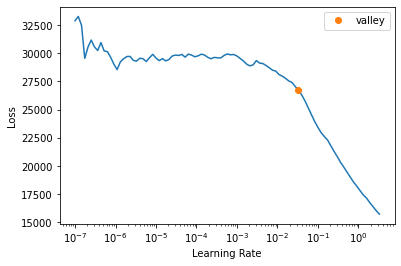

<Figure size 720x720 with 0 Axes>

XGBoost Predictions vs Actual==========
   actual  predicted
0  281.88     279.44
1   21.25      21.25
2  230.94     231.25
3   20.46      20.50
4   15.90      15.71
XGBoost RMSE:  2.4697697


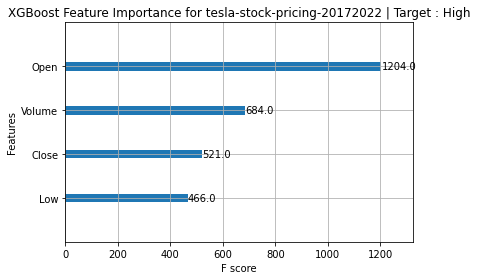

<Figure size 432x288 with 0 Axes>

In [19]:

if SEP_DOLLAR:
    #For every column in df, if the column contains a $, make a new column with the value without the $
    for col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')


if SEP_PERCENT:
    #For every column in df, if the column contains a %, make a new column with the value without the %
    for col in df.columns:
        if '%' in df[col].to_string():
            df[col + '_no_percent'] = df[col].str.replace('%', '').str.replace(',', '')

target = ''
target_str = ''
#The column closest to the end isPARAM_DIR the target variable that can be represented as a float is the target variable
targets = []
#Loop through every possible target column (Continuous)
for i in range(len(df.columns)-1, 0, -1):
    try:
        df[df.columns[i]] = df[df.columns[i]].astype(float)
        target = df.columns[i]
        target_str = target.replace('/', '-')
    except:
        continue
    print(f'Target Variable: {target}')
    #Will be determined by the file name


    #===================================================================================================

    #Create project config files if they don't exist.
    if not os.path.exists(param_dir):
        #create param_dir
        os.makedirs(PARAM_DIR)
    if not os.path.exists(f'{PARAM_DIR}/cats.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/cats.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/conts.txt'):
        #create param_dir
        with open(f'{PARAM_DIR}/conts.txt', 'w') as f:
            f.write('')
    if not os.path.exists(f'{PARAM_DIR}/cols_to_delete.txt'):
        with open(f'{PARAM_DIR}/cols_to_delete.txt', 'w') as f:
            f.write('')

    df = df.drop_duplicates()
    if SHUFFLE_DATA:
        df = df.sample(frac=1).reset_index(drop=True)

    # workaround for fastai/pytorch bug where bool is treated as object and thus erroring out.
    for n in df:
        if pd.api.types.is_bool_dtype(df[n]):
            df[n] = df[n].astype('uint8')

    with open(f'{PARAM_DIR}/cols_to_delete.txt', 'r') as f:
        cols_to_delete = f.read().splitlines()
    for col in cols_to_delete:
        try:
            del(df[col])
        except:
            pass
    #try to fill in missing values now, otherwise FastAI will do it for us later
    try:
        df = df.fillna(0)
    except:
        pass
    #print missing values
    #print(df.isna().sum().sort_values(ascending=False))
    #shrink df as much as possible
    df = df_shrink(df)


    #print types inside of df
    #print(df.dtypes)


    #Auto detect categorical and continuous variables
    #==============================================================================
    likely_cat = {}
    for var in df.columns:
        likely_cat[var] = 1.*df[var].nunique()/df[var].count() < 0.05 #or some other threshold

    cats = [var for var in df.columns if likely_cat[var]]
    conts = [var for var in df.columns if not likely_cat[var]]

    #remove target from lists
    try:
        conts.remove(target)
        cats.remove(target)
    except:
        pass
    #Convert target to float
    df[target] = df[target].astype(float)

    print('CATS=====================')
    print(cats)
    print('CONTS=====================')
    print(conts)

    #Populate categorical and continuous lists
    #==============================================================================

    if VARIABLE_FILES == True:
        with open(f'{PARAM_DIR}/cats.txt', 'r') as f:
            cats = f.read().splitlines()

        with open(f'{PARAM_DIR}/conts.txt', 'r') as f:
            conts = f.read().splitlines()

    #==============================================================================

    #==============================================================================
    procs = [Categorify, FillMissing, Normalize]
    #print(df.describe().T)
    df = df[0:SAMPLE_COUNT]
    splits = RandomSplitter()(range_of(df))

    print((len(cats)) + len(conts))
    #conts = []

    #Convert cont variables to floats
    #==============================================================================

    #Convert cont variables to floats
    #==============================================================================

    for var in conts:
        try:
            df[var] = df[var].astype(float)
        except:
            print(f'Could not convert {var} to float.')
            pass

    #==============================================================================

    #Experimental logic to add columns one-by-one to find a breakpoint
    #==============================================================================
    if ENABLE_BREAKPOINT == True:
        temp_procs = [Categorify, FillMissing]
        print('Looping through continuous variables to find breakpoint')
        cont_list = []
        for cont in conts:
            focus_cont = cont
            cont_list.append(cont)
            #print(focus_cont)
            try:
                to = TabularPandas(df, procs=procs, cat_names=cats, cont_names=cont_list, y_names=target, y_block=RegressionBlock(), splits=splits)
                del(to)
            except:
                print('Error with ', focus_cont)
                #remove focus_cont from list
                cont_list.remove(focus_cont)
                #traceback.print_exc()
                continue
        #convert all continuous variables to floats
        for var in cont_list:
            try:
                df[var] = df[var].astype(float)
            except:
                print(f'Could not convert {var} to float.')
                cont_list.remove(var)
                if CONVERT_TO_CAT == True:
                    cats.append(var)
                pass
        print(f'Continuous variables that made the cut : {cont_list}')
        print(f'Categorical variables that made the cut : {cats}')
        #shrink df as much as possible
        df = df_shrink(df)
        #print(df.dtypes)

    #==============================================================================

    #Creating tabular object + quick preprocessing
    #==============================================================================
    to = None
    if REGRESSOR == True:
        try:
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, y_block=RegressionBlock(), splits=splits)
    else:
        try:
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)
        except:
            conts = []
            to = TabularPandas(df, procs, cats, conts, target, splits=splits)

    #print(dir(to))
    #print(to.xs)
    dls = to.dataloaders()
    print(f'Tabular Object size: {len(to)}')
    try:
        dls.one_batch()
    except:
        print(f'problem with getting one batch of {PROJECT_NAME}')
    #==============================================================================

    #Extracting train and test sets from tabular object
    #==============================================================================

    X_train, y_train = to.train.xs, to.train.ys.values.ravel()
    X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

    #Make sure target isn't in independent columns
    if target in X_train and target in X_test:
        del(X_train[target])
        del(X_test[target])
    #create dataframe from X_train and y_train
    #export tabular object to csv
    pd.DataFrame(X_train).to_csv(f'{PARAM_DIR}/X_train_{target_str}.csv', index=False)
    pd.DataFrame(X_test).to_csv(f'{PARAM_DIR}/X_test_{target_str}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'{PARAM_DIR}/y_train_{target_str}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'{PARAM_DIR}/y_test_{target_str}.csv', index=False)

    #==============================================================================

    #==============================================================================

    #Ready for model selection!

    if REGRESSOR == True:
        try:
            reg = LazyRegressor(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = reg.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            target_std = y_train.std()
            print(f'Target Standard Deviation: {target_std}')
            print(models)
            models['project'] = PROJECT_NAME
            models['target'] = target
            models['target_std'] = target_std
            #rename index of 
            models.to_csv(f'{PARAM_DIR}/regression_results_{target_str}.csv', mode='a', header=True, index=True)
        except:
            print('Issue during lazypredict analysis')
    else:
        #TODO: remove this
        try:
            clf = LazyClassifier(verbose=2, ignore_warnings=False, custom_metric=None)
            models, predictions = clf.fit(X_train, X_test, y_train, y_test)
            print(f'Project: {PROJECT_NAME}')
            print(PROJECT_NAME)
            print(f'Target: {target}')
            print(target)
            print(f'Target Standard Deviation: {y_train.std()}')
            print(models)
            models.to_csv(f'{PARAM_DIR}/classification_results.csv', mode='a', header=False)
        except:
            print('Issue during lazypredict analysis')

    model_name = 'tabnet'

    # FastAI + pre-trained TabNet
    #==============================================================================
    learn = None
    i = 0
    while True:
        try:
            del learn
        except:
            pass
        try:
            learn = 0
            model = TabNetModel(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
            # save the best model so far, determined by early stopping
            cbs = [SaveModelCallback(monitor='_rmse', comp=np.less, fname=f'{model_name}_{PROJECT_NAME}_{target_str}_best'), EarlyStoppingCallback()]
            learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=rmse, cbs=cbs)
            #learn = get_learner(to)
            if(learn != 0):
                break
            if i > 50:
                break
        except:
            i += 1
            print('Error in FastAI TabNet')
            traceback.print_exc()
            continue
    try:
        #display learning rate finder results
        x = learn.lr_find()
    except:
        pass
    if AUTO_ADJUST_LEARNING_RATE == True:
        FASTAI_LEARNING_RATE = x.valley
    print(f'LEARNING RATE: {FASTAI_LEARNING_RATE}')
    try:
        if i < 50:
            learn.fit_one_cycle(20, FASTAI_LEARNING_RATE)
            plt.figure(figsize=(10, 10))
            try:
                ax = learn.show_results()
                plt.show(block=True)
            except:
                print('Could not show results')
                pass
    except:
        print('Could not fit model')
        traceback.print_exc()
        pass

    #==============================================================================

    #fit an xgboost model
    #==============================================================================
    if REGRESSOR == True:
        xgb = XGBRegressor()
    else:
        xgb = XGBClassifier()
    try:
        xgb = XGBRegressor()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        print('XGBoost Predictions vs Actual==========')
        print(pd.DataFrame({'actual': y_test, 'predicted': y_pred}).head())
        print('XGBoost RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))
        #save feature importance plot to file
        plot_importance(xgb)
        plt.title(f'XGBoost Feature Importance for {PROJECT_NAME} | Target : {target}', wrap=True)
        plt.tight_layout()
        plt.show()
        plt.savefig(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.png')
        fi_df = pd.DataFrame([xgb.get_booster().get_score()]).T
        fi_df.columns = ['importance']
        #create a column based off the index called feature
        fi_df['feature'] = fi_df.index
        #create a dataframe of feature importance
        fi_df = fi_df[['feature', 'importance']]
        fi_df.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv', index=False)
        #xgb_fi = pd.DataFrame(xgb.feature_importances_, index=X_train.columns, columns=['importance'])
        #xgb_fi.to_csv(f'{PARAM_DIR}/xgb_feature_importance_{target_str}.csv')
        #print('XGBoost AUC: ', roc_auc_score(y_test, y_pred))
    except:
        traceback.print_exc()
        print('XGBoost failed')

# <div style="text-align: center; background-color: blue; color: white; padding: 14px; line-height: 1;border-radius:20px">**Overall Feature Importance**</div>

  feature  importance
0    Open     1000.00
1    High      774.00
2     Low      689.00
3   Close      391.00
0    Open      777.00


<AxesSubplot:title={'center':'XGBoost Overall Feature Importance'}, xlabel='feature'>

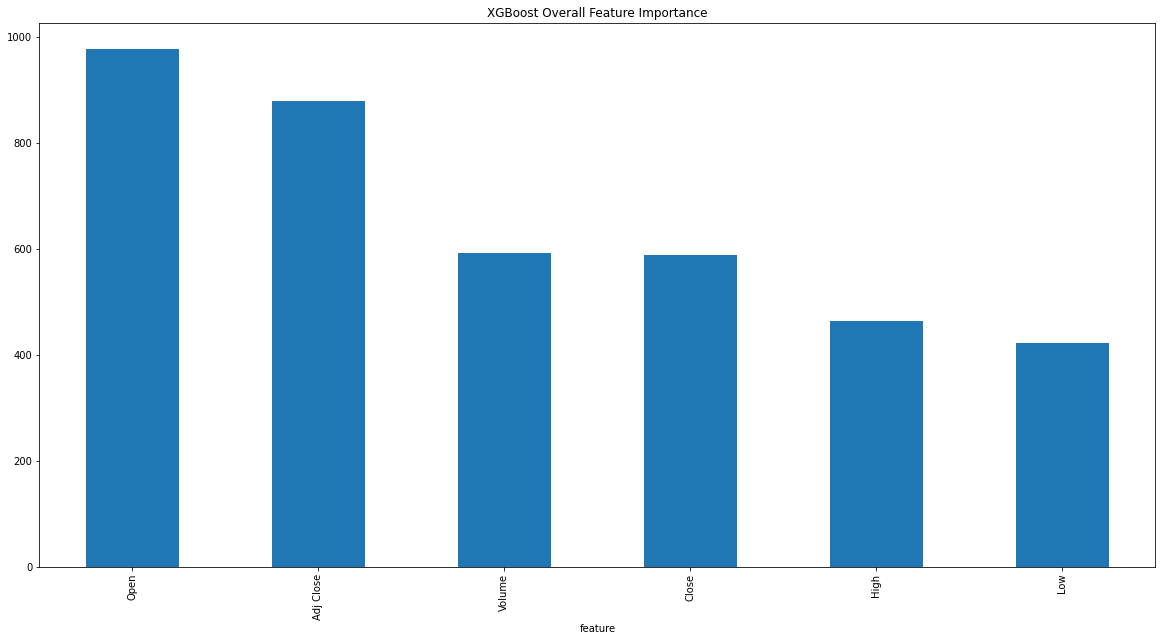

In [20]:
out_dir = f'./{PROJECT_NAME}'
xgb_feature_importance_csvs = []

for file in os.listdir(out_dir):
    if 'xgb_feature_importance' in file and '.csv' in file:
        xgb_feature_importance_csvs.append(pd.read_csv(os.path.join(out_dir, file)))

xgb_feature_importance = pd.concat(xgb_feature_importance_csvs,axis=0)
xgb_feature_importance.rename(columns={'Unnamed: 0': 'feature'}, inplace=True)
print(xgb_feature_importance.head())
xgb_feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).plot(kind='bar', title='XGBoost Overall Feature Importance', figsize=(20, 10))

In [21]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

# **To Be Continued...**